In [1]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.7 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.6/215.6 kB 11.0 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=c2e7ebe069e7d5d9610242a1122247b03c51df5ccb26bebf37403de1e43d00d9
  Stored in directory: /home/jovyan/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [2]:
!pip install git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git

  Cloning https://github.com/ildoonet/pytorch-gradual-warmup-lr.git to /tmp/pip-req-build-f3mk8p_6
  Running command git clone --filter=blob:none --quiet https://github.com/ildoonet/pytorch-gradual-warmup-lr.git /tmp/pip-req-build-f3mk8p_6
  Resolved https://github.com/ildoonet/pytorch-gradual-warmup-lr.git to commit 6b5e8953a80aef5b324104dc0c2e9b8c34d622bd
  Preparing metadata (setup.py) ... done
  Created wheel for warmup-scheduler: filename=warmup_scheduler-0.3.2-py3-none-any.whl size=3863 sha256=2b176c6b9bebb773f05dde5c689f3b8ef9dce04601fb01cbb39755c46df47bb1
  Stored in directory: /tmp/pip-ephem-wheel-cache-v_8i0elm/wheels/49/78/e6/9168d5844935482a171c7880a0626fa1c6c412b55666635f59
Successfully built warmup-scheduler


In [3]:
import pandas as pd
import numpy as np
import random

from tqdm import tqdm
import wandb

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
from warmup_scheduler import GradualWarmupScheduler

import torchaudio
import torchaudio.transforms as T
from torchaudio.transforms import AmplitudeToDB, Vol

device = torch.device("cuda:0")

In [4]:
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /home/jovyan/.netrc


True

### Custom Dataset

In [16]:
class AudioDataset(Dataset):

    def __init__(self, path_speech, path_noise, eps_value=1e-6,\
                 mel_nframes=300, sample_rate=16000, n_fft=480,\
                 hop_length=160, n_mels=40):

        self.speech = pd.read_csv(path_speech)
        self.noise = pd.read_csv(path_noise)
        self.eps_value = eps_value
        self.mel_nframes = mel_nframes
        self.sample_rate = sample_rate
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_mels = n_mels
        self.mel_spectrogram = T.MelSpectrogram(sample_rate=self.sample_rate,
                                                n_fft=self.n_fft,
                                                hop_length=self.hop_length,
                                                center=True,
                                                pad_mode="reflect",
                                                power=2.0,
                                                norm='slaney',
                                                n_mels=self.n_mels)

    def __len__(self):

        return len(self.noise)

    def get_same_shape(self, waveform, w_type):

        melsp = torch.log(self.mel_spectrogram(waveform) + self.eps_value)
        has_mel_nframes = melsp.size(2) if melsp.size(2) < self.mel_nframes\
         else self.mel_nframes

        image_tens = torch.full((1, self.n_mels, self.mel_nframes), melsp.min())
        image_tens[0, :, :has_mel_nframes] = melsp[:, :, :has_mel_nframes]

        return image_tens

    def load_item(self, df, idx, w_type):

        sample_wav_file = df['filename'][idx]
        wave, _ = torchaudio.load(sample_wav_file)
        wave = wave.float()

        if w_type==1:
            wave_noise = wave.numpy()
            wave_noise_no_silence = [float(el) for el in wave_noise[0] if abs(el) >= 0.001]
            wave = torch.tensor([wave_noise_no_silence])

        wave_melsp = self.get_same_shape(wave, w_type)

        return wave_melsp

    def __getitem__(self, idx):

        wave_speech = self.load_item(self.speech, idx, w_type=0)

        luck = random.random()
        if luck > 0.5:
            wave_noise = self.load_item(self.noise, idx, w_type=1)

            wave_out = wave_speech + wave_noise
            label = 1

        else:
            wave_out = wave_speech
            label = 0

        return wave_out, torch.tensor(label)

In [17]:
audio_dataset_train = AudioDataset('./CleanSpeechTrain.csv',
                                   './NoiseTrain.csv')

audio_dataset_val = AudioDataset('./CleanSpeechVal.csv',
                                   './NoiseVal.csv')

audio_dataset_test = AudioDataset('./CleanSpeechTest.csv',
                                   './NoiseTest.csv')

### Data Loader

In [18]:
train_loader = DataLoader(dataset=audio_dataset_train,
                          batch_size=100, drop_last=True, num_workers=4)

val_loader = DataLoader(dataset=audio_dataset_val,
                        batch_size=100, drop_last=True, num_workers=4)

test_loader = DataLoader(dataset=audio_dataset_test,
                         batch_size=100, drop_last=True, num_workers=4)

### Train functions

In [19]:
def compute_accuracy(model, loader):

    model.eval()

    correct_samples = 0
    total_samples = 0

    for i, (x, y) in enumerate(loader):

        x_gpu = x.to(device)
        y_gpu = y.to(device)

        prediction = model(x_gpu).squeeze(1)
        correct_samples += torch.sum(prediction.round()==y_gpu)
        total_samples += y_gpu.size(0)

    return float(correct_samples) / total_samples

In [20]:
def train(model, train_loader, val_loader, loss,
          optimizer, warmup_scheduler, num_epochs):

    wandb.init(
        project='Noise-Estimation',
        config={'learning_rate': 1e-3,
                'model': 'BCResNet',
                'loss': 'BCELoss',
                'optimizer': 'Adam',
                'scheduler': 'WarmUp and CosineAnnealing',
                'T_max': 20,
                'total_epochs': 30,
                'epochs': 50,
                'batch_size': 100}
    )

    loss_history = []
    train_history = []
    val_history = []

    for epoch in range(num_epochs):
        model.train()

        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        num_batches = 0

        with tqdm(total=len(train_loader),
                  desc=f'Epoch {epoch+1}',
                  leave=True) as pb:

            for i, (x, y) in enumerate(train_loader):

                x_gpu = x.to(device)
                y_gpu = y.to(device)

                optimizer.zero_grad()
                prediction = model(x_gpu).squeeze(1)

                loss_value = loss(prediction, y_gpu.float())
                loss_value.backward()
                optimizer.step()

                correct_samples += torch.sum(prediction.round()==y_gpu)
                total_samples += y.size(0)
                loss_accum += loss_value

                pb.update()
                pb.set_description( f'Epoch {epoch+1}:'
                                    f' Average epoch loss: {loss_accum / num_batches:.3f}'
                                    f' Train accuracy:'
                                    f' {correct_samples/total_samples:.2f},'
                                    )
                num_batches += 1

            ave_loss = loss_accum / num_batches
            train_accuracy = float(correct_samples) / total_samples
            val_accuracy = compute_accuracy(model, val_loader)

            if warmup_scheduler:
                warmup_scheduler.step()

            loss_history.append(float(ave_loss))
            train_history.append(train_accuracy)
            val_history.append(val_accuracy)

            wandb.log({'Epoch': epoch+1, 'loss': ave_loss,
                       'train_acc': train_accuracy,
                       'val_acc': val_accuracy})

            pb.set_description( f'Epoch {epoch+1}:'
                                f' Average epoch loss: {ave_loss:.3f}'
                                f' Train accuracy: {train_accuracy:.2f},'
                                f' Val accuracy: {val_accuracy:.2f}'
                                )

    wandb.finish()
    return loss_history, train_history, val_history

### MHAttKWS

In [17]:
from BCResNet import MHAttKWS
model_mhat = MHAttKWS(num_classes=1)
model_mhat.type(torch.cuda.FloatTensor)
model_mhat.to(device)

loss = nn.BCEWithLogitsLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(model_mhat.parameters(), lr=1e-2)
cosine_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40, verbose=True)
warmup_scheduler = GradualWarmupScheduler(optimizer, multiplier=1, total_epoch=40,
                                          after_scheduler=cosine_scheduler)

Adjusting learning rate of group 0 to 1.0000e-02.


In [18]:
loss_history, train_history, val_history = train(model_mhat, train_loader,
                                                 val_loader, loss,
                                                 optimizer, warmup_scheduler,
                                                 num_epochs=50)

Epoch,▁▂▃▄▅▆▇█
loss,█▄▄▃▂▁▁▁
train_acc,█▃▄▅▄▂▇▁
val_acc,█▁▁▄▅▅▃▃
Epoch,8
loss,0.69293
train_acc,0.49574
val_acc,0.499


Epoch 1: Average epoch loss: 0.693 Train accuracy: 0.49, Val accuracy: 0.50: 100%|██████████| 61/61 [00:54<00:00,  1.12it/s]
Epoch 2: Average epoch loss: 0.693 Train accuracy: 0.49, Val accuracy: 0.51: 100%|██████████| 61/61 [00:52<00:00,  1.16it/s]
Epoch 3: Average epoch loss: 0.695 Train accuracy: 0.52, Val accuracy: 0.50: 100%|██████████| 61/61 [00:53<00:00,  1.13it/s]
Epoch 4: Average epoch loss: 0.694 Train accuracy: 0.51, Val accuracy: 0.52: 100%|██████████| 61/61 [00:52<00:00,  1.15it/s]
Epoch 5: Average epoch loss: 0.694 Train accuracy: 0.50, Val accuracy: 0.47: 100%|██████████| 61/61 [00:54<00:00,  1.13it/s]
Epoch 6: Average epoch loss: 0.693 Train accuracy: 0.49, Val accuracy: 0.51: 100%|██████████| 61/61 [00:54<00:00,  1.12it/s]
Epoch 7: Average epoch loss: 0.694 Train accuracy: 0.50, Val accuracy: 0.53: 100%|██████████| 61/61 [00:52<00:00,  1.16it/s]
Epoch 8: Average epoch loss: 0.693 Train accuracy: 0.49, Val accuracy: 0.49: 100%|██████████| 61/61 [00:55<00:00,  1.11it/s]


Adjusting learning rate of group 0 to 9.9846e-03.


Epoch 43: Average epoch loss: 0.690 Train accuracy: 0.50, Val accuracy: 0.51: 100%|██████████| 61/61 [00:52<00:00,  1.15it/s]


Adjusting learning rate of group 0 to 9.9384e-03.


Epoch 44: Average epoch loss: 0.690 Train accuracy: 0.51, Val accuracy: 0.49: 100%|██████████| 61/61 [00:54<00:00,  1.13it/s]


Adjusting learning rate of group 0 to 9.8618e-03.


Epoch 45: Average epoch loss: 0.689 Train accuracy: 0.49, Val accuracy: 0.50: 100%|██████████| 61/61 [00:53<00:00,  1.13it/s]


Adjusting learning rate of group 0 to 9.7553e-03.


Epoch 46: Average epoch loss: 0.689 Train accuracy: 0.50, Val accuracy: 0.51: 100%|██████████| 61/61 [00:52<00:00,  1.16it/s]


Adjusting learning rate of group 0 to 9.6194e-03.


Epoch 47: Average epoch loss: 0.688 Train accuracy: 0.50, Val accuracy: 0.48: 100%|██████████| 61/61 [00:54<00:00,  1.13it/s]


Adjusting learning rate of group 0 to 9.4550e-03.


Epoch 48: Average epoch loss: 0.688 Train accuracy: 0.50, Val accuracy: 0.50: 100%|██████████| 61/61 [00:54<00:00,  1.11it/s]


Adjusting learning rate of group 0 to 9.2632e-03.


Epoch 49: Average epoch loss: 0.687 Train accuracy: 0.49, Val accuracy: 0.51: 100%|██████████| 61/61 [00:54<00:00,  1.11it/s]


Adjusting learning rate of group 0 to 9.0451e-03.


Epoch 50: Average epoch loss: 0.687 Train accuracy: 0.50, Val accuracy: 0.49: 100%|██████████| 61/61 [00:53<00:00,  1.14it/s]

Adjusting learning rate of group 0 to 8.8020e-03.


Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,▇▇█▇▆▇▆▇▇▇▇▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▂▂▁
train_acc,▄▄█▆▄▅▄▆▅▇▇▅▅▃▄▃▆▆▆▇▇▆▅▄▆▇▆▇▇▇▁▄█▃▆▇▆▅▆▅
val_acc,▅▆▅▇▅█▄▂█▅█▄▁▂▃▄▆▆▆▄▅▃▅█▅▅▄▆▃▄▂▅▅▃▅▃▅▂▅▃
Epoch,50
loss,0.68664
train_acc,0.49902
val_acc,0.488


In [13]:
# torch.cuda.empty_cache()

In [10]:
!nvidia-smi

Failed to initialize NVML: Unknown Error


### BCResNet

In [21]:
from BCResNet import BCResNet
model_bcrn = BCResNet(num_labels=1)
model_bcrn.type(torch.cuda.FloatTensor)
model_bcrn.to(device)

loss = nn.BCELoss().type(torch.cuda.FloatTensor)
optimizer = optim.Adam(model_bcrn.parameters(),
                       lr=1e-3)
cosine_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, verbose=True)
warmup_scheduler = GradualWarmupScheduler(optimizer, multiplier=1, total_epoch=30,
                                          after_scheduler=cosine_scheduler)

Adjusting learning rate of group 0 to 1.0000e-03.


In [22]:
loss_history, train_history, val_history = train(model_bcrn, train_loader,
                                                 val_loader, loss,
                                                 optimizer, warmup_scheduler, num_epochs=50)

Epoch 1: Average epoch loss: 0.691 Train accuracy: 0.53, Val accuracy: 0.50: 100%|██████████| 30/30 [00:56<00:00,  1.87s/it]
Epoch 2: Average epoch loss: 0.690 Train accuracy: 0.55, Val accuracy: 0.74: 100%|██████████| 30/30 [00:54<00:00,  1.83s/it]
Epoch 3: Average epoch loss: 0.683 Train accuracy: 0.62, Val accuracy: 0.71: 100%|██████████| 30/30 [00:54<00:00,  1.83s/it]
Epoch 4: Average epoch loss: 0.670 Train accuracy: 0.64, Val accuracy: 0.89: 100%|██████████| 30/30 [00:56<00:00,  1.87s/it]
Epoch 5: Average epoch loss: 0.644 Train accuracy: 0.67, Val accuracy: 0.99: 100%|██████████| 30/30 [00:55<00:00,  1.86s/it]
Epoch 6: Average epoch loss: 0.558 Train accuracy: 0.93, Val accuracy: 1.00: 100%|██████████| 30/30 [00:56<00:00,  1.88s/it]
Epoch 7: Average epoch loss: 0.364 Train accuracy: 0.99, Val accuracy: 1.00: 100%|██████████| 30/30 [00:53<00:00,  1.78s/it]
Epoch 8: Average epoch loss: 0.147 Train accuracy: 1.00, Val accuracy: 1.00: 100%|██████████| 30/30 [00:56<00:00,  1.89s/it]


Adjusting learning rate of group 0 to 9.9384e-04.


Epoch 33: Average epoch loss: 0.000 Train accuracy: 1.00, Val accuracy: 1.00: 100%|██████████| 30/30 [00:56<00:00,  1.88s/it]


Adjusting learning rate of group 0 to 9.7553e-04.


Epoch 34: Average epoch loss: 0.000 Train accuracy: 1.00, Val accuracy: 1.00: 100%|██████████| 30/30 [00:53<00:00,  1.79s/it]


Adjusting learning rate of group 0 to 9.4550e-04.


Epoch 35: Average epoch loss: 0.000 Train accuracy: 1.00, Val accuracy: 1.00: 100%|██████████| 30/30 [00:57<00:00,  1.93s/it]


Adjusting learning rate of group 0 to 9.0451e-04.


Epoch 36: Average epoch loss: 0.000 Train accuracy: 1.00, Val accuracy: 1.00: 100%|██████████| 30/30 [00:55<00:00,  1.84s/it]


Adjusting learning rate of group 0 to 8.5355e-04.


Epoch 37: Average epoch loss: 0.000 Train accuracy: 1.00, Val accuracy: 1.00: 100%|██████████| 30/30 [00:54<00:00,  1.81s/it]


Adjusting learning rate of group 0 to 7.9389e-04.


Epoch 38: Average epoch loss: 0.000 Train accuracy: 1.00, Val accuracy: 1.00: 100%|██████████| 30/30 [00:55<00:00,  1.84s/it]


Adjusting learning rate of group 0 to 7.2700e-04.


Epoch 39: Average epoch loss: 0.000 Train accuracy: 1.00, Val accuracy: 1.00: 100%|██████████| 30/30 [00:57<00:00,  1.90s/it]


Adjusting learning rate of group 0 to 6.5451e-04.


Epoch 40: Average epoch loss: 0.000 Train accuracy: 1.00, Val accuracy: 1.00: 100%|██████████| 30/30 [00:58<00:00,  1.94s/it]


Adjusting learning rate of group 0 to 5.7822e-04.


Epoch 41: Average epoch loss: 0.000 Train accuracy: 1.00, Val accuracy: 1.00: 100%|██████████| 30/30 [00:55<00:00,  1.87s/it]


Adjusting learning rate of group 0 to 5.0000e-04.


Epoch 42: Average epoch loss: 0.000 Train accuracy: 1.00, Val accuracy: 1.00: 100%|██████████| 30/30 [00:56<00:00,  1.90s/it]


Adjusting learning rate of group 0 to 4.2178e-04.


Epoch 43: Average epoch loss: 0.000 Train accuracy: 1.00, Val accuracy: 1.00: 100%|██████████| 30/30 [00:56<00:00,  1.90s/it]


Adjusting learning rate of group 0 to 3.4549e-04.


Epoch 44: Average epoch loss: 0.000 Train accuracy: 1.00, Val accuracy: 1.00: 100%|██████████| 30/30 [00:55<00:00,  1.85s/it]


Adjusting learning rate of group 0 to 2.7300e-04.


Epoch 45: Average epoch loss: 0.000 Train accuracy: 1.00, Val accuracy: 1.00: 100%|██████████| 30/30 [00:54<00:00,  1.80s/it]


Adjusting learning rate of group 0 to 2.0611e-04.


Epoch 46: Average epoch loss: 0.000 Train accuracy: 1.00, Val accuracy: 1.00: 100%|██████████| 30/30 [00:55<00:00,  1.85s/it]


Adjusting learning rate of group 0 to 1.4645e-04.


Epoch 47: Average epoch loss: 0.001 Train accuracy: 1.00, Val accuracy: 1.00: 100%|██████████| 30/30 [00:54<00:00,  1.81s/it]


Adjusting learning rate of group 0 to 9.5492e-05.


Epoch 48: Average epoch loss: 0.000 Train accuracy: 1.00, Val accuracy: 1.00: 100%|██████████| 30/30 [00:58<00:00,  1.96s/it]


Adjusting learning rate of group 0 to 5.4497e-05.


Epoch 49: Average epoch loss: 0.000 Train accuracy: 1.00, Val accuracy: 1.00: 100%|██████████| 30/30 [00:57<00:00,  1.91s/it]


Adjusting learning rate of group 0 to 2.4472e-05.


Epoch 50: Average epoch loss: 0.000 Train accuracy: 1.00, Val accuracy: 1.00: 100%|██████████| 30/30 [00:56<00:00,  1.88s/it]

Adjusting learning rate of group 0 to 6.1558e-06.


Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,████▇▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▁▂▃▇███████████████████████████████████
val_acc,▁▄▄▆████████████████████████████████████
Epoch,50
loss,0.00043
train_acc,0.99967
val_acc,1.0


In [23]:
torch.save(model_bcrn.state_dict(), 'weights_bcrn1.pth')

In [24]:
torch.save(optimizer.state_dict(), 'optimizer_bcrn1.pth')

In [25]:
bcrn_test_accuracy = compute_accuracy(model_bcrn, test_loader)
print(f'VGG model test accuracy: {bcrn_test_accuracy:.2f}')

VGG model test accuracy: 1.00


### VGG

In [11]:
from vggNet import VGGModel

model_vgg = VGGModel(1, 'vgg11')
model_vgg.to(device)
model_vgg.type(torch.cuda.FloatTensor)

loss = nn.BCELoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(model_vgg.parameters(), lr=1e-3)
cosine_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, verbose=True)
warmup_scheduler = GradualWarmupScheduler(optimizer, multiplier=1, total_epoch=25,
                                          after_scheduler=cosine_scheduler)

Adjusting learning rate of group 0 to 1.0000e-03.


In [12]:
loss_history, train_history, val_history = train(model_vgg, train_loader,
                                                 val_loader, loss,
                                                 optimizer, warmup_scheduler,
                                                 num_epochs=80)

wandb: Currently logged in as: darya-dare. Use `wandb login --relogin` to force relogin


Epoch 1: Average epoch loss: 0.743 Train accuracy: 0.52, Val accuracy: 0.49: 100%|██████████| 30/30 [00:57<00:00,  1.92s/it]
Epoch 2: Average epoch loss: 0.714 Train accuracy: 0.51, Val accuracy: 0.51: 100%|██████████| 30/30 [00:57<00:00,  1.92s/it]
Epoch 3: Average epoch loss: 0.695 Train accuracy: 0.51, Val accuracy: 0.50: 100%|██████████| 30/30 [00:55<00:00,  1.85s/it]
Epoch 4: Average epoch loss: 0.682 Train accuracy: 0.53, Val accuracy: 0.50: 100%|██████████| 30/30 [00:59<00:00,  2.00s/it]
Epoch 5: Average epoch loss: 0.679 Train accuracy: 0.52, Val accuracy: 0.48: 100%|██████████| 30/30 [00:57<00:00,  1.92s/it]
Epoch 6: Average epoch loss: 0.678 Train accuracy: 0.52, Val accuracy: 0.51: 100%|██████████| 30/30 [00:54<00:00,  1.83s/it]
Epoch 7: Average epoch loss: 0.658 Train accuracy: 0.54, Val accuracy: 0.50: 100%|██████████| 30/30 [00:58<00:00,  1.97s/it]
Epoch 8: Average epoch loss: 0.659 Train accuracy: 0.54, Val accuracy: 0.51: 100%|██████████| 30/30 [00:59<00:00,  1.97s/it]


Adjusting learning rate of group 0 to 9.9901e-04.


Epoch 28: Average epoch loss: 0.201 Train accuracy: 0.94, Val accuracy: 0.98: 100%|██████████| 30/30 [00:56<00:00,  1.87s/it]


Adjusting learning rate of group 0 to 9.9606e-04.


Epoch 29: Average epoch loss: 0.197 Train accuracy: 0.93, Val accuracy: 0.98: 100%|██████████| 30/30 [00:57<00:00,  1.92s/it]


Adjusting learning rate of group 0 to 9.9114e-04.


Epoch 30: Average epoch loss: 0.232 Train accuracy: 0.92, Val accuracy: 0.98: 100%|██████████| 30/30 [00:57<00:00,  1.92s/it]


Adjusting learning rate of group 0 to 9.8429e-04.


Epoch 31: Average epoch loss: 0.092 Train accuracy: 0.98, Val accuracy: 0.99: 100%|██████████| 30/30 [00:56<00:00,  1.87s/it]


Adjusting learning rate of group 0 to 9.7553e-04.


Epoch 32: Average epoch loss: 0.078 Train accuracy: 0.98, Val accuracy: 0.99: 100%|██████████| 30/30 [00:57<00:00,  1.93s/it]


Adjusting learning rate of group 0 to 9.6489e-04.


Epoch 33: Average epoch loss: 0.402 Train accuracy: 0.84, Val accuracy: 0.99: 100%|██████████| 30/30 [00:56<00:00,  1.89s/it]


Adjusting learning rate of group 0 to 9.5241e-04.


Epoch 34: Average epoch loss: 0.093 Train accuracy: 0.98, Val accuracy: 0.99: 100%|██████████| 30/30 [00:59<00:00,  1.99s/it]


Adjusting learning rate of group 0 to 9.3815e-04.


Epoch 35: Average epoch loss: 0.054 Train accuracy: 0.99, Val accuracy: 0.99: 100%|██████████| 30/30 [00:57<00:00,  1.92s/it]


Adjusting learning rate of group 0 to 9.2216e-04.


Epoch 36: Average epoch loss: 0.051 Train accuracy: 0.99, Val accuracy: 0.99: 100%|██████████| 30/30 [00:56<00:00,  1.87s/it]


Adjusting learning rate of group 0 to 9.0451e-04.


Epoch 37: Average epoch loss: 0.042 Train accuracy: 0.99, Val accuracy: 0.99: 100%|██████████| 30/30 [00:57<00:00,  1.92s/it]


Adjusting learning rate of group 0 to 8.8526e-04.


Epoch 38: Average epoch loss: 0.037 Train accuracy: 0.99, Val accuracy: 0.99: 100%|██████████| 30/30 [00:59<00:00,  1.97s/it]


Adjusting learning rate of group 0 to 8.6448e-04.


Epoch 39: Average epoch loss: 0.035 Train accuracy: 0.99, Val accuracy: 0.99: 100%|██████████| 30/30 [00:55<00:00,  1.85s/it]


Adjusting learning rate of group 0 to 8.4227e-04.


Epoch 40: Average epoch loss: 0.031 Train accuracy: 0.99, Val accuracy: 1.00: 100%|██████████| 30/30 [00:56<00:00,  1.88s/it]


Adjusting learning rate of group 0 to 8.1871e-04.


Epoch 41: Average epoch loss: 0.029 Train accuracy: 0.99, Val accuracy: 0.99: 100%|██████████| 30/30 [00:57<00:00,  1.92s/it]


Adjusting learning rate of group 0 to 7.9389e-04.


Epoch 42: Average epoch loss: 0.027 Train accuracy: 1.00, Val accuracy: 0.99: 100%|██████████| 30/30 [00:55<00:00,  1.85s/it]


Adjusting learning rate of group 0 to 7.6791e-04.


Epoch 43: Average epoch loss: 0.024 Train accuracy: 1.00, Val accuracy: 0.99: 100%|██████████| 30/30 [00:58<00:00,  1.94s/it]


Adjusting learning rate of group 0 to 7.4088e-04.


Epoch 44: Average epoch loss: 0.024 Train accuracy: 0.99, Val accuracy: 1.00: 100%|██████████| 30/30 [00:57<00:00,  1.93s/it]


Adjusting learning rate of group 0 to 7.1289e-04.


Epoch 45: Average epoch loss: 0.019 Train accuracy: 1.00, Val accuracy: 1.00: 100%|██████████| 30/30 [00:57<00:00,  1.92s/it]


Adjusting learning rate of group 0 to 6.8406e-04.


Epoch 46: Average epoch loss: 0.018 Train accuracy: 1.00, Val accuracy: 1.00: 100%|██████████| 30/30 [00:56<00:00,  1.88s/it]


Adjusting learning rate of group 0 to 6.5451e-04.


Epoch 47: Average epoch loss: 0.022 Train accuracy: 0.99, Val accuracy: 1.00: 100%|██████████| 30/30 [00:57<00:00,  1.92s/it]


Adjusting learning rate of group 0 to 6.2434e-04.


Epoch 48: Average epoch loss: 0.020 Train accuracy: 0.99, Val accuracy: 1.00: 100%|██████████| 30/30 [00:57<00:00,  1.92s/it]


Adjusting learning rate of group 0 to 5.9369e-04.


Epoch 49: Average epoch loss: 0.017 Train accuracy: 1.00, Val accuracy: 1.00: 100%|██████████| 30/30 [00:57<00:00,  1.93s/it]


Adjusting learning rate of group 0 to 5.6267e-04.


Epoch 50: Average epoch loss: 0.021 Train accuracy: 0.99, Val accuracy: 1.00: 100%|██████████| 30/30 [00:55<00:00,  1.84s/it]


Adjusting learning rate of group 0 to 5.3140e-04.


Epoch 51: Average epoch loss: 0.019 Train accuracy: 1.00, Val accuracy: 1.00: 100%|██████████| 30/30 [00:58<00:00,  1.94s/it]


Adjusting learning rate of group 0 to 5.0000e-04.


Epoch 52: Average epoch loss: 0.017 Train accuracy: 1.00, Val accuracy: 1.00: 100%|██████████| 30/30 [00:57<00:00,  1.91s/it]


Adjusting learning rate of group 0 to 4.6860e-04.


Epoch 53: Average epoch loss: 0.016 Train accuracy: 1.00, Val accuracy: 1.00: 100%|██████████| 30/30 [00:58<00:00,  1.94s/it]


Adjusting learning rate of group 0 to 4.3733e-04.


Epoch 54: Average epoch loss: 0.014 Train accuracy: 1.00, Val accuracy: 1.00: 100%|██████████| 30/30 [00:56<00:00,  1.89s/it]


Adjusting learning rate of group 0 to 4.0631e-04.


Epoch 55: Average epoch loss: 0.013 Train accuracy: 1.00, Val accuracy: 1.00: 100%|██████████| 30/30 [00:54<00:00,  1.83s/it]


Adjusting learning rate of group 0 to 3.7566e-04.


Epoch 56: Average epoch loss: 0.013 Train accuracy: 1.00, Val accuracy: 1.00: 100%|██████████| 30/30 [00:58<00:00,  1.95s/it]


Adjusting learning rate of group 0 to 3.4549e-04.


Epoch 57: Average epoch loss: 0.016 Train accuracy: 1.00, Val accuracy: 1.00: 100%|██████████| 30/30 [00:58<00:00,  1.95s/it]


Adjusting learning rate of group 0 to 3.1594e-04.


Epoch 58: Average epoch loss: 0.015 Train accuracy: 1.00, Val accuracy: 1.00: 100%|██████████| 30/30 [00:59<00:00,  1.97s/it]


Adjusting learning rate of group 0 to 2.8711e-04.


Epoch 59: Average epoch loss: 0.015 Train accuracy: 1.00, Val accuracy: 1.00: 100%|██████████| 30/30 [00:57<00:00,  1.92s/it]


Adjusting learning rate of group 0 to 2.5912e-04.


Epoch 60: Average epoch loss: 0.012 Train accuracy: 1.00, Val accuracy: 1.00: 100%|██████████| 30/30 [00:58<00:00,  1.95s/it]


Adjusting learning rate of group 0 to 2.3209e-04.


Epoch 61: Average epoch loss: 0.016 Train accuracy: 1.00, Val accuracy: 1.00: 100%|██████████| 30/30 [00:58<00:00,  1.95s/it]


Adjusting learning rate of group 0 to 2.0611e-04.


Epoch 62: Average epoch loss: 0.013 Train accuracy: 1.00, Val accuracy: 1.00: 100%|██████████| 30/30 [00:54<00:00,  1.83s/it]


Adjusting learning rate of group 0 to 1.8129e-04.


Epoch 63: Average epoch loss: 0.015 Train accuracy: 1.00, Val accuracy: 1.00: 100%|██████████| 30/30 [00:58<00:00,  1.97s/it]


Adjusting learning rate of group 0 to 1.5773e-04.


Epoch 64: Average epoch loss: 0.013 Train accuracy: 1.00, Val accuracy: 1.00: 100%|██████████| 30/30 [00:57<00:00,  1.93s/it]


Adjusting learning rate of group 0 to 1.3552e-04.


Epoch 65: Average epoch loss: 0.013 Train accuracy: 1.00, Val accuracy: 1.00: 100%|██████████| 30/30 [00:56<00:00,  1.90s/it]


Adjusting learning rate of group 0 to 1.1474e-04.


Epoch 66: Average epoch loss: 0.013 Train accuracy: 1.00, Val accuracy: 1.00: 100%|██████████| 30/30 [00:55<00:00,  1.85s/it]


Adjusting learning rate of group 0 to 9.5492e-05.


Epoch 67: Average epoch loss: 0.012 Train accuracy: 1.00, Val accuracy: 1.00: 100%|██████████| 30/30 [00:58<00:00,  1.94s/it]


Adjusting learning rate of group 0 to 7.7836e-05.


Epoch 68: Average epoch loss: 0.014 Train accuracy: 1.00, Val accuracy: 1.00: 100%|██████████| 30/30 [00:57<00:00,  1.90s/it]


Adjusting learning rate of group 0 to 6.1847e-05.


Epoch 69: Average epoch loss: 0.011 Train accuracy: 1.00, Val accuracy: 1.00: 100%|██████████| 30/30 [00:56<00:00,  1.88s/it]


Adjusting learning rate of group 0 to 4.7586e-05.


Epoch 70: Average epoch loss: 0.012 Train accuracy: 1.00, Val accuracy: 1.00: 100%|██████████| 30/30 [00:56<00:00,  1.90s/it]


Adjusting learning rate of group 0 to 3.5112e-05.


Epoch 71: Average epoch loss: 0.013 Train accuracy: 1.00, Val accuracy: 0.99: 100%|██████████| 30/30 [00:57<00:00,  1.92s/it]


Adjusting learning rate of group 0 to 2.4472e-05.


Epoch 72: Average epoch loss: 0.013 Train accuracy: 1.00, Val accuracy: 1.00: 100%|██████████| 30/30 [00:57<00:00,  1.90s/it]


Adjusting learning rate of group 0 to 1.5708e-05.


Epoch 73: Average epoch loss: 0.014 Train accuracy: 1.00, Val accuracy: 1.00: 100%|██████████| 30/30 [00:57<00:00,  1.91s/it]


Adjusting learning rate of group 0 to 8.8564e-06.


Epoch 74: Average epoch loss: 0.012 Train accuracy: 1.00, Val accuracy: 1.00: 100%|██████████| 30/30 [00:59<00:00,  1.98s/it]


Adjusting learning rate of group 0 to 3.9426e-06.


Epoch 75: Average epoch loss: 0.013 Train accuracy: 1.00, Val accuracy: 1.00: 100%|██████████| 30/30 [00:57<00:00,  1.93s/it]


Adjusting learning rate of group 0 to 9.8664e-07.


Epoch 76: Average epoch loss: 0.012 Train accuracy: 1.00, Val accuracy: 1.00: 100%|██████████| 30/30 [00:56<00:00,  1.87s/it]


Adjusting learning rate of group 0 to 0.0000e+00.


Epoch 77: Average epoch loss: 0.012 Train accuracy: 1.00, Val accuracy: 1.00: 100%|██████████| 30/30 [00:56<00:00,  1.88s/it]


Adjusting learning rate of group 0 to 9.8664e-07.


Epoch 78: Average epoch loss: 0.011 Train accuracy: 1.00, Val accuracy: 1.00: 100%|██████████| 30/30 [00:56<00:00,  1.88s/it]


Adjusting learning rate of group 0 to 3.9426e-06.


Epoch 79: Average epoch loss: 0.012 Train accuracy: 1.00, Val accuracy: 1.00: 100%|██████████| 30/30 [00:58<00:00,  1.95s/it]


Adjusting learning rate of group 0 to 8.8564e-06.


Epoch 80: Average epoch loss: 0.012 Train accuracy: 1.00, Val accuracy: 1.00: 100%|██████████| 30/30 [00:55<00:00,  1.86s/it]

Adjusting learning rate of group 0 to 1.5708e-05.


Epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,██▇▇▇▇▇▆▆▅▅▄▄▃▃▂▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▁▁▁▂▂▂▃▅▆▆▆▆▇▇█▆███████████████████████
val_acc,▂▂▁▂▁▂▂▆▅▇▇▂▇███████████████████████████
Epoch,80
loss,0.01185
train_acc,0.998
val_acc,0.999


In [13]:
torch.save(model_vgg.state_dict(), 'weights_vgg1.pth')

In [14]:
torch.save(optimizer.state_dict(), 'optimizer_vgg1.pth')

In [15]:
vgg_test_accuracy = compute_accuracy(model_vgg, test_loader)
print(f'VGG model test accuracy: {vgg_test_accuracy:.2f}')

VGG model test accuracy: 1.00


### Trial Dataset

In [15]:
class TrialDataset(Dataset):

    def __init__(self, path_noise, eps_value=1e-6,\
                 mel_nframes=300, sample_rate=16000, n_fft=480,\
                 hop_length=160, n_mels=40):

        self.noise = pd.read_csv(path_noise)
        self.wave_still = torch.empty(1, 40, 300)
        self.eps_value = eps_value
        self.mel_nframes = mel_nframes
        self.sample_rate = sample_rate
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_mels = n_mels
        self.mel_spectrogram = T.MelSpectrogram(sample_rate=self.sample_rate,
                                                n_fft=self.n_fft,
                                                hop_length=self.hop_length,
                                                center=True,
                                                pad_mode="reflect",
                                                power=2.0,
                                                norm='slaney',
                                                n_mels=self.n_mels)

    def __len__(self):

        return len(self.noise)

    def get_same_shape(self, waveform):

        # melsp = torch.log(self.mel_spectrogram(waveform) + self.eps_value)
        melsp = self.mel_spectrogram(waveform)
        has_mel_nframes = melsp.size(2) if melsp.size(2) < self.mel_nframes\
         else self.mel_nframes

        image_tens = torch.full((1, self.n_mels, self.mel_nframes), melsp.min())
        image_tens[0, :, :has_mel_nframes] = melsp[:, :, :has_mel_nframes]

        return image_tens

    def load_item(self, df, idx):

        sample_wav_file = df['filename'][idx]
        wave, _ = torchaudio.load(sample_wav_file)
        wave = wave.float()

        wave_melsp = self.get_same_shape(wave)

        return wave_melsp

    def __getitem__(self, idx):

        luck = random.random()
        if luck >= 0.5:
            wave_out = self.load_item(self.noise, idx)
            label = 1

        else:
            wave_out = torch.fill(self.wave_still, -1)
            label = 0

        return wave_out, torch.tensor(label).type(torch.cuda.FloatTensor)

In [16]:
trial_dataset_train = TrialDataset('./NoiseTrain.csv')

trial_dataset_val = TrialDataset('./NoiseVal.csv')

1.0


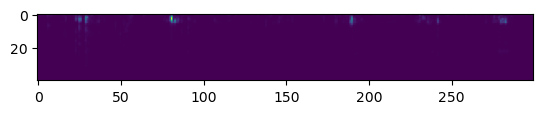

In [6]:
melspec,label = trial_dataset_train[5]
print(label.item())
import matplotlib.pyplot as plt
plt.imshow(melspec.squeeze(0))
plt.show()

### Data Loader

In [17]:
train_loader = DataLoader(dataset=trial_dataset_train,
                          batch_size=64, drop_last=True)

val_loader = DataLoader(dataset=trial_dataset_val,
                        batch_size=64, drop_last=True)

### Train function

In [8]:
# def get_preds_for_bce(prediction, target):
#     correct_preds = []
    
#     for i in range(len(target)):
#         if target[i] == 0:
#             correct_preds.append(prediction[i][0])
#         else:
#             correct_preds.append(prediction[i][1])
    
#     return torch.tensor(correct_preds).type(torch.cuda.FloatTensor)

In [18]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [19]:
def compute_accuracy(model, loader):

    model.eval()

    correct_samples = 0
    total_samples = 0

    for i, (x, y) in enumerate(loader):
        
        x_gpu = x.to(device)
        y_gpu = y.to(device)

        prediction = model(x_gpu)
        indices = torch.argmax(prediction, 1)
        correct_samples += torch.sum(indices==y_gpu)
        total_samples += y.size(0)

    return float(correct_samples) / total_samples

In [23]:
def train_trial(model, train_loader, val_loader, loss,
          optimizer, warmup_scheduler, num_epochs):

    wandb.init(
        project='Silence-Noise',
        config={'learning_rate': 1e-3,
                'model': 'VGG',
                'loss': 'BCELoss',
                'optimizer': 'SGD',
                'scheduler': 'None',
                'epochs': num_epochs}
    )

    loss_history = []
    train_history = []
    val_history = []

    for epoch in range(num_epochs):
        model.train()

        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        num_batches = 0
        print(f"Epoch # {epoch+1} - LR: {get_lr(optimizer)}")
        
        with tqdm(total=len(train_loader),
                  desc=f'Epoch {epoch+1}',
                  leave=True) as pb:

            for i, (x, y) in enumerate(train_loader):

                x_gpu = x.to(device)
                y_gpu = y.to(device)

                optimizer.zero_grad()
                prediction = model(x_gpu).squeeze(1)
                
                # preds = get_preds_for_bce(prediction, y_gpu)
                # preds.requires_grad_()
                # preds_gpu = preds.to(device)
                
                
                # BUG: Considering all other changes, we don't need that
                #values, indices = torch.max(prediction, 1)
                
                # BUG: we put prediction to loss function, not inference results
                # loss_value = loss(values, y_gpu.float())
                loss_value = loss(prediction, y_gpu.float())
                loss_value.backward()
                optimizer.step()

                correct_samples += torch.sum(prediction.round()==y_gpu)
                total_samples += y.size(0)
                loss_accum += loss_value

                pb.update()
                # BUG: Average loss should be loss_accum/num_batches
                pb.set_description( f'Epoch {epoch+1}:' 
                                    f' LR: {get_lr(optimizer)}'
                                    f' Average epoch loss: {loss_accum/num_batches:.3f}'
                                    f' Train accuracy:'
                                    f' {correct_samples/total_samples:.2f},'
                                    )
                num_batches += 1
            
            # BUG: was /epoch+1, needs to be /num_batches
            # ave_loss = loss_accum / /epoch+1
            ave_loss = loss_accum / num_batches
            train_accuracy = float(correct_samples) / total_samples
            val_accuracy = compute_accuracy(model, val_loader)
            
            if warmup_scheduler:
                warmup_scheduler.step()

            loss_history.append(float(ave_loss))
            train_history.append(train_accuracy)
            val_history.append(val_accuracy)

            wandb.log({'Epoch': epoch+1, 'loss': ave_loss,
                       'train_acc': train_accuracy,
                       'val_acc': val_accuracy})
            pb.set_description( f'Epoch {epoch+1}:'
                                f' Average epoch loss: {loss_accum/num_batches:.3f}'
                                f' Train accuracy: {train_accuracy:.2f},'
                                f' Val accuracy: {val_accuracy:.2f}'
                                )

    wandb.finish()
    return loss_history, train_history, val_history

### VGG

In [24]:
# BUG: more like a suggestion, but model should be recreated with each run, so I'd put it here
# BUG: model should have 1 as first argument, not 2, because essentially we can use 1 output from the model with threshold in case of binary classification in spite of having 2 labels
from vggNet import VGGModel
model_vgg = VGGModel(1, 'vgg11')
model_vgg.to(device)
model_vgg.type(torch.cuda.FloatTensor)

loss = nn.BCELoss().type(torch.cuda.FloatTensor)

optimizer = optim.SGD(model_vgg.parameters(), lr=1e-3)

# cosine_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, verbose=True)

#warmup_scheduler = GradualWarmupScheduler(optimizer, multiplier=1, total_epoch=50,
#                                          after_scheduler=cosine_scheduler)

In [25]:
loss_history, train_history, val_history = train_trial(
    model_vgg, train_loader, val_loader, loss, 
    optimizer, None, num_epochs=50)

Epoch,▁
loss,▁
train_acc,▁
val_acc,▁
Epoch,1
loss,0.68452
train_acc,0.62142
val_acc,0.5166


Epoch # 1 - LR: 0.001


Epoch 1: Average epoch loss: 0.682 Train accuracy: 0.62, Val accuracy: 0.50: 100%|██████████| 48/48 [00:15<00:00,  3.08it/s]


Epoch # 2 - LR: 0.001


Epoch 2: Average epoch loss: 0.665 Train accuracy: 0.67, Val accuracy: 0.51: 100%|██████████| 48/48 [00:14<00:00,  3.32it/s]


Epoch # 3 - LR: 0.001


Epoch 3: Average epoch loss: 0.642 Train accuracy: 0.59, Val accuracy: 0.48: 100%|██████████| 48/48 [00:14<00:00,  3.30it/s]


Epoch # 4 - LR: 0.001


Epoch 4: Average epoch loss: 0.598 Train accuracy: 0.54, Val accuracy: 0.50: 100%|██████████| 48/48 [00:14<00:00,  3.30it/s]


Epoch # 5 - LR: 0.001


Epoch 5: Average epoch loss: 0.527 Train accuracy: 0.51, Val accuracy: 0.48: 100%|██████████| 48/48 [00:14<00:00,  3.30it/s]


Epoch # 6 - LR: 0.001


Epoch 6: Average epoch loss: 0.453 Train accuracy: 0.53, Val accuracy: 0.49: 100%|██████████| 48/48 [00:14<00:00,  3.29it/s]


Epoch # 7 - LR: 0.001


Epoch 7: Average epoch loss: 0.406 Train accuracy: 0.70, Val accuracy: 0.51: 100%|██████████| 48/48 [00:14<00:00,  3.29it/s]


Epoch # 8 - LR: 0.001


Epoch 8: Average epoch loss: 0.366 Train accuracy: 0.91, Val accuracy: 0.51: 100%|██████████| 48/48 [00:14<00:00,  3.28it/s]


Epoch # 9 - LR: 0.001


Epoch 9: Average epoch loss: 0.326 Train accuracy: 0.99, Val accuracy: 0.49: 100%|██████████| 48/48 [00:14<00:00,  3.30it/s]


Epoch # 10 - LR: 0.001


Epoch 10: Average epoch loss: 0.291 Train accuracy: 1.00, Val accuracy: 0.50: 100%|██████████| 48/48 [00:14<00:00,  3.29it/s]


Epoch # 11 - LR: 0.001


Epoch 11: Average epoch loss: 0.263 Train accuracy: 1.00, Val accuracy: 0.50: 100%|██████████| 48/48 [00:14<00:00,  3.28it/s]


Epoch # 12 - LR: 0.001


Epoch 12: Average epoch loss: 0.219 Train accuracy: 1.00, Val accuracy: 0.50: 100%|██████████| 48/48 [00:14<00:00,  3.29it/s]


Epoch # 13 - LR: 0.001


Epoch 13: Average epoch loss: 0.184 Train accuracy: 1.00, Val accuracy: 0.50: 100%|██████████| 48/48 [00:14<00:00,  3.30it/s]


Epoch # 14 - LR: 0.001


Epoch 14: Average epoch loss: 0.146 Train accuracy: 1.00, Val accuracy: 0.50: 100%|██████████| 48/48 [00:14<00:00,  3.22it/s]


Epoch # 15 - LR: 0.001


Epoch 15: Average epoch loss: 0.116 Train accuracy: 1.00, Val accuracy: 0.49: 100%|██████████| 48/48 [00:14<00:00,  3.29it/s]


Epoch # 16 - LR: 0.001


Epoch 16: Average epoch loss: 0.086 Train accuracy: 1.00, Val accuracy: 0.50: 100%|██████████| 48/48 [00:14<00:00,  3.29it/s]


Epoch # 17 - LR: 0.001


Epoch 17: Average epoch loss: 0.066 Train accuracy: 1.00, Val accuracy: 0.50: 100%|██████████| 48/48 [00:14<00:00,  3.30it/s]


Epoch # 18 - LR: 0.001


Epoch 18: Average epoch loss: 0.050 Train accuracy: 1.00, Val accuracy: 0.53: 100%|██████████| 48/48 [00:14<00:00,  3.30it/s]


Epoch # 19 - LR: 0.001


Epoch 19: Average epoch loss: 0.040 Train accuracy: 1.00, Val accuracy: 0.50: 100%|██████████| 48/48 [00:14<00:00,  3.29it/s]


Epoch # 20 - LR: 0.001


Epoch 20: Average epoch loss: 0.034 Train accuracy: 1.00, Val accuracy: 0.51: 100%|██████████| 48/48 [00:14<00:00,  3.26it/s]


Epoch # 21 - LR: 0.001


Epoch 21: Average epoch loss: 0.026 Train accuracy: 1.00, Val accuracy: 0.53: 100%|██████████| 48/48 [00:14<00:00,  3.29it/s]


Epoch # 22 - LR: 0.001


Epoch 22: Average epoch loss: 0.021 Train accuracy: 1.00, Val accuracy: 0.50: 100%|██████████| 48/48 [00:14<00:00,  3.29it/s]


Epoch # 23 - LR: 0.001


Epoch 23: Average epoch loss: 0.018 Train accuracy: 1.00, Val accuracy: 0.51: 100%|██████████| 48/48 [00:14<00:00,  3.29it/s]


Epoch # 24 - LR: 0.001


Epoch 24: Average epoch loss: 0.015 Train accuracy: 1.00, Val accuracy: 0.49: 100%|██████████| 48/48 [00:14<00:00,  3.28it/s]


Epoch # 25 - LR: 0.001


Epoch 25: Average epoch loss: 0.013 Train accuracy: 1.00, Val accuracy: 0.49: 100%|██████████| 48/48 [00:14<00:00,  3.28it/s]


Epoch # 26 - LR: 0.001


Epoch 26: Average epoch loss: 0.011 Train accuracy: 1.00, Val accuracy: 0.50: 100%|██████████| 48/48 [00:14<00:00,  3.32it/s]


Epoch # 27 - LR: 0.001


Epoch 27: Average epoch loss: 0.009 Train accuracy: 1.00, Val accuracy: 0.46: 100%|██████████| 48/48 [00:14<00:00,  3.29it/s]


Epoch # 28 - LR: 0.001


Epoch 28: Average epoch loss: 0.009 Train accuracy: 1.00, Val accuracy: 0.49: 100%|██████████| 48/48 [00:14<00:00,  3.29it/s]


Epoch # 29 - LR: 0.001


Epoch 29: Average epoch loss: 0.008 Train accuracy: 1.00, Val accuracy: 0.51: 100%|██████████| 48/48 [00:14<00:00,  3.27it/s]


Epoch # 30 - LR: 0.001


Epoch 30: Average epoch loss: 0.007 Train accuracy: 1.00, Val accuracy: 0.51: 100%|██████████| 48/48 [00:14<00:00,  3.30it/s]


Epoch # 31 - LR: 0.001


Epoch 31: Average epoch loss: 0.006 Train accuracy: 1.00, Val accuracy: 0.48: 100%|██████████| 48/48 [00:14<00:00,  3.27it/s]


Epoch # 32 - LR: 0.001


Epoch 32: Average epoch loss: 0.006 Train accuracy: 1.00, Val accuracy: 0.49: 100%|██████████| 48/48 [00:14<00:00,  3.29it/s]


Epoch # 33 - LR: 0.001


Epoch 33: Average epoch loss: 0.005 Train accuracy: 1.00, Val accuracy: 0.51: 100%|██████████| 48/48 [00:14<00:00,  3.28it/s]


Epoch # 34 - LR: 0.001


Epoch 34: Average epoch loss: 0.005 Train accuracy: 1.00, Val accuracy: 0.49: 100%|██████████| 48/48 [00:14<00:00,  3.28it/s]


Epoch # 35 - LR: 0.001


Epoch 35: Average epoch loss: 0.004 Train accuracy: 1.00, Val accuracy: 0.51: 100%|██████████| 48/48 [00:14<00:00,  3.24it/s]


Epoch # 36 - LR: 0.001


Epoch 36: Average epoch loss: 0.004 Train accuracy: 1.00, Val accuracy: 0.50: 100%|██████████| 48/48 [00:14<00:00,  3.27it/s]


Epoch # 37 - LR: 0.001


Epoch 37: Average epoch loss: 0.004 Train accuracy: 1.00, Val accuracy: 0.54: 100%|██████████| 48/48 [00:14<00:00,  3.29it/s]


Epoch # 38 - LR: 0.001


Epoch 38: Average epoch loss: 0.003 Train accuracy: 1.00, Val accuracy: 0.50: 100%|██████████| 48/48 [00:14<00:00,  3.30it/s]


Epoch # 39 - LR: 0.001


Epoch 39: Average epoch loss: 0.003 Train accuracy: 1.00, Val accuracy: 0.51: 100%|██████████| 48/48 [00:14<00:00,  3.29it/s]


Epoch # 40 - LR: 0.001


Epoch 40: Average epoch loss: 0.003 Train accuracy: 1.00, Val accuracy: 0.50: 100%|██████████| 48/48 [00:14<00:00,  3.29it/s]


Epoch # 41 - LR: 0.001


Epoch 41: Average epoch loss: 0.003 Train accuracy: 1.00, Val accuracy: 0.50: 100%|██████████| 48/48 [00:14<00:00,  3.29it/s]


Epoch # 42 - LR: 0.001


Epoch 42: Average epoch loss: 0.003 Train accuracy: 1.00, Val accuracy: 0.48: 100%|██████████| 48/48 [00:14<00:00,  3.29it/s]


Epoch # 43 - LR: 0.001


Epoch 43: Average epoch loss: 0.003 Train accuracy: 1.00, Val accuracy: 0.53: 100%|██████████| 48/48 [00:14<00:00,  3.29it/s]


Epoch # 44 - LR: 0.001


Epoch 44: Average epoch loss: 0.003 Train accuracy: 1.00, Val accuracy: 0.50: 100%|██████████| 48/48 [00:14<00:00,  3.29it/s]


Epoch # 45 - LR: 0.001


Epoch 45: Average epoch loss: 0.002 Train accuracy: 1.00, Val accuracy: 0.48: 100%|██████████| 48/48 [00:14<00:00,  3.28it/s]


Epoch # 46 - LR: 0.001


Epoch 46: Average epoch loss: 0.002 Train accuracy: 1.00, Val accuracy: 0.47: 100%|██████████| 48/48 [00:14<00:00,  3.29it/s]


Epoch # 47 - LR: 0.001


Epoch 47: Average epoch loss: 0.002 Train accuracy: 1.00, Val accuracy: 0.49: 100%|██████████| 48/48 [00:14<00:00,  3.29it/s]


Epoch # 48 - LR: 0.001


Epoch 48: Average epoch loss: 0.002 Train accuracy: 1.00, Val accuracy: 0.53: 100%|██████████| 48/48 [00:14<00:00,  3.30it/s]


Epoch # 49 - LR: 0.001


Epoch 49: Average epoch loss: 0.002 Train accuracy: 1.00, Val accuracy: 0.50: 100%|██████████| 48/48 [00:14<00:00,  3.26it/s]


Epoch # 50 - LR: 0.001


Epoch 50: Average epoch loss: 0.002 Train accuracy: 1.00, Val accuracy: 0.51: 100%|██████████| 48/48 [00:14<00:00,  3.20it/s]


Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,███▇▆▅▅▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▂▃▂▁▁▄▇█████████████████████████████████
val_acc,▄▅▃▄▃▅▅▃▄▅▅▄▅▅▇▄▇▄▅▄▅▁▄▅▂▄▅▃▅█▄▅▅▃▇▅▂▄▇▅
Epoch,50
loss,0.00186
train_acc,1.0
val_acc,0.51172
